In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# this cell is a snippet for taking a photo using a browser (for eval purposes)

from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [ ]:
import pathlib
%ls /content/drive/MyDrive/unprocessed/
data_dir="/content/drive/MyDrive/grayscale"
data_dir = pathlib.Path(data_dir)
image_count = len(list(data_dir.glob('*/*.jpeg')))
print(image_count)

neko/  non_neko/
2579


In [ ]:
# Install TensorFlow and other required libraries
!pip install -q tensorflow

!pip install -q wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 25.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 14.4 MB/s eta 0:00:00


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import datetime

import os

import wandb
from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint

%load_ext tensorboard

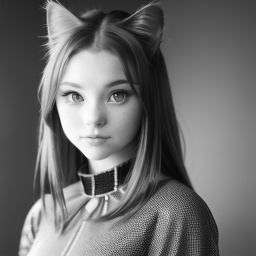

In [ ]:
nekos = list(data_dir.glob('neko/*'))
PIL.Image.open(str(nekos[0]))

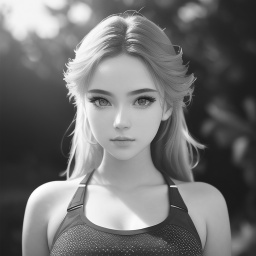

In [ ]:
nonnekos = list(data_dir.glob('non_neko/*'))
PIL.Image.open(str(nonnekos[0]))

In [ ]:
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3" # to shut up tf

config={
    "img_height": 256,
    "img_width": 256,
    "batch_size": 64,
    "padding": "same",
    "activation": "relu",
    "optimizer": "adam",
    "metrics": ["accuracy"],
    "loss": "sparse_categorical_crossentropy",
    "num_epochs": 20
    }

!wandb login

wandb.init(project="neko-classifier")
wandb.config.update(config)

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: simtoon (simtoonia). Use `wandb login --relogin` to force relogin


In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.15,
  subset="training",
  seed=6858357,
  image_size=(config["img_height"], config["img_width"]),
  batch_size=config["batch_size"])

Found 2579 files belonging to 2 classes.
Using 2193 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.15,
  subset="validation",
  seed=6858357,
  image_size=(config["img_height"], config["img_width"]),
  batch_size=config["batch_size"])

Found 2579 files belonging to 2 classes.
Using 386 files for validation.


In [ ]:
class_names = train_ds.class_names

num_classes = len(class_names)

print(val_ds.class_names)

print(class_names)

print(config["batch_size"])
print(type(config["batch_size"]))

['neko', 'non_neko']
['neko', 'non_neko']
64
<class 'int'>


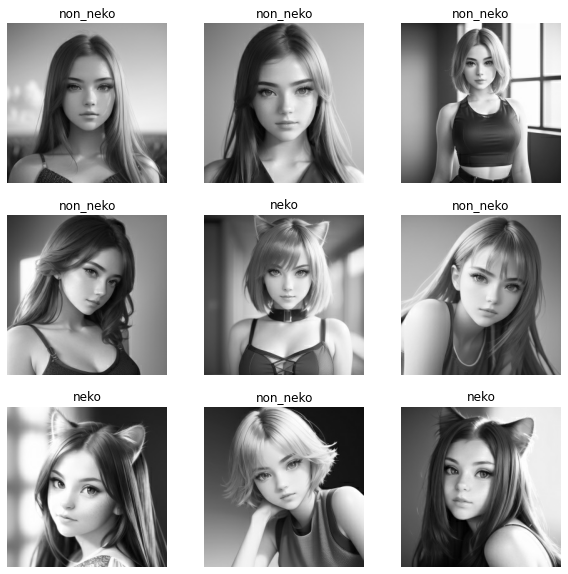

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
normalization_layer = layers.Rescaling(1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


0.0 1.0


In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(config["img_height"],
                                  config["img_width"],
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

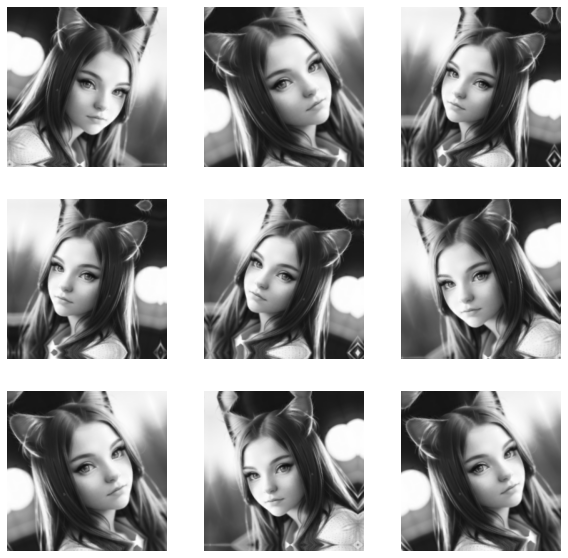

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
# pulled out data_augmentation from the first layer since I'm experimenting with training without it. put back if the results are bad !!!
model = Sequential([
  layers.Rescaling(1./255, input_shape=(config["img_height"], config["img_width"], 3)),
  layers.Conv2D(16, 3, padding=config["padding"], activation=config["activation"]),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding=config["padding"], activation=config["activation"]),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding=config["padding"], activation=config["activation"]),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation=config["activation"]),
  layers.Dense(num_classes)
])
print(num_classes)

2


In [ ]:
model.compile(optimizer=config["optimizer"],
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=[config["metrics"]])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)       

In [ ]:
cpkt_callback = tf.keras.callbacks.ModelCheckpoint(filepath="ckpt/neko_classifier",
                                                save_weights_only=True,verbose=1,save_freq=5)
logs = "content/drive/MyDrive/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tb_callback = tf.keras.callbacks.TensorBoard(log_dir=logs, histogram_freq=1)

In [ ]:
epochs=config["num_epochs"]
print(epochs)

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[cpkt_callback, tb_callback, WandbMetricsLogger(log_freq=5), WandbModelCheckpoint("ckpt/neko_classifier")]
)

20
Epoch 1/20
 4/35 [==>...........................] - ETA: 3s - loss: 2.0691 - accuracy: 0.4766
Epoch 1: saving model to ckpt/neko_classifier
 6/35 [====>.........................] - ETA: 6s - loss: 1.7554 - accuracy: 0.4629

 9/35 [======>.......................] - ETA: 4s - loss: 1.3785 - accuracy: 0.4953
Epoch 1: saving model to ckpt/neko_classifier
14/35 [===========>..................] - ETA: 4s - loss: 1.1193 - accuracy: 0.4935
Epoch 1: saving model to ckpt/neko_classifier
19/35 [===============>..............] - ETA: 3s - loss: 0.9991 - accuracy: 0.5269
Epoch 1: saving model to ckpt/neko_classifier
24/35 [===================>..........] - ETA: 2s - loss: 0.9292 - accuracy: 0.5447
Epoch 1: saving model to ckpt/neko_classifier
29/35 [=======================>......] - ETA: 1s - loss: 0.8825 - accuracy: 0.5550
Epoch 1: saving model to ckpt/neko_classifier
34/35 [============================>.] - ETA: 0s - loss: 0.8461 - accuracy: 0.5660
Epoch 1: saving model to ckpt/neko_classifier
35/35 [==============================] - ETA: 0s - loss: 0.8390 - accuracy: 0.5695

wandb: Adding directory to artifact (./ckpt/neko_classifier)... Done. 0.3s


35/35 [==============================] - 126s 3s/step - loss: 0.8390 - accuracy: 0.5695 - val_loss: 0.6685 - val_accuracy: 0.5777
Epoch 2/20
 4/35 [==>...........................] - ETA: 3s - loss: 0.6127 - accuracy: 0.6523
Epoch 2: saving model to ckpt/neko_classifier
 9/35 [======>.......................] - ETA: 3s - loss: 0.5686 - accuracy: 0.7135
Epoch 2: saving model to ckpt/neko_classifier
14/35 [===========>..................] - ETA: 3s - loss: 0.5556 - accuracy: 0.7310
Epoch 2: saving model to ckpt/neko_classifier
19/35 [===============>..............] - ETA: 2s - loss: 0.5330 - accuracy: 0.7451
Epoch 2: saving model to ckpt/neko_classifier
23/35 [==================>...........] - ETA: 1s - loss: 0.5144 - accuracy: 0.7527
Epoch 2: saving model to ckpt/neko_classifier
29/35 [=======================>......] - ETA: 0s - loss: 0.5021 - accuracy: 0.7551
Epoch 2: saving model to ckpt/neko_classifier
34/35 [============================>.] - ETA: 0s - loss: 0.4896 - accuracy: 0.7666
Ep

wandb: Adding directory to artifact (./ckpt/neko_classifier)... Done. 0.4s


35/35 [==============================] - 11s 308ms/step - loss: 0.4865 - accuracy: 0.7679 - val_loss: 0.3975 - val_accuracy: 0.8212
Epoch 3/20
 4/35 [==>...........................] - ETA: 3s - loss: 0.2989 - accuracy: 0.9091
Epoch 3: saving model to ckpt/neko_classifier
 9/35 [======>.......................] - ETA: 4s - loss: 0.2983 - accuracy: 0.9017
Epoch 3: saving model to ckpt/neko_classifier
14/35 [===========>..................] - ETA: 4s - loss: 0.3284 - accuracy: 0.8775
Epoch 3: saving model to ckpt/neko_classifier
19/35 [===============>..............] - ETA: 3s - loss: 0.3368 - accuracy: 0.8717
Epoch 3: saving model to ckpt/neko_classifier
24/35 [===================>..........] - ETA: 2s - loss: 0.3354 - accuracy: 0.8704
Epoch 3: saving model to ckpt/neko_classifier
29/35 [=======================>......] - ETA: 1s - loss: 0.3287 - accuracy: 0.8701
Epoch 3: saving model to ckpt/neko_classifier
34/35 [============================>.] - ETA: 0s - loss: 0.3230 - accuracy: 0.8760


wandb: Adding directory to artifact (./ckpt/neko_classifier)... Done. 0.3s


35/35 [==============================] - 13s 370ms/step - loss: 0.3229 - accuracy: 0.8755 - val_loss: 0.2884 - val_accuracy: 0.8808
Epoch 4/20
 4/35 [==>...........................] - ETA: 3s - loss: 0.2226 - accuracy: 0.9219
Epoch 4: saving model to ckpt/neko_classifier
 9/35 [======>.......................] - ETA: 3s - loss: 0.1905 - accuracy: 0.9392
Epoch 4: saving model to ckpt/neko_classifier
14/35 [===========>..................] - ETA: 3s - loss: 0.1822 - accuracy: 0.9397
Epoch 4: saving model to ckpt/neko_classifier
19/35 [===============>..............] - ETA: 2s - loss: 0.1898 - accuracy: 0.9359
Epoch 4: saving model to ckpt/neko_classifier
24/35 [===================>..........] - ETA: 1s - loss: 0.1888 - accuracy: 0.9382
Epoch 4: saving model to ckpt/neko_classifier
29/35 [=======================>......] - ETA: 0s - loss: 0.1907 - accuracy: 0.9359
Epoch 4: saving model to ckpt/neko_classifier
34/35 [============================>.] - ETA: 0s - loss: 0.1905 - accuracy: 0.9347


wandb: Adding directory to artifact (./ckpt/neko_classifier)... Done. 0.3s


35/35 [==============================] - 11s 329ms/step - loss: 0.1922 - accuracy: 0.9330 - val_loss: 0.2253 - val_accuracy: 0.9119
Epoch 5/20
 4/35 [==>...........................] - ETA: 4s - loss: 0.1576 - accuracy: 0.9648
Epoch 5: saving model to ckpt/neko_classifier
 9/35 [======>.......................] - ETA: 5s - loss: 0.1306 - accuracy: 0.9583
Epoch 5: saving model to ckpt/neko_classifier
14/35 [===========>..................] - ETA: 5s - loss: 0.1332 - accuracy: 0.9542
Epoch 5: saving model to ckpt/neko_classifier
19/35 [===============>..............] - ETA: 3s - loss: 0.1391 - accuracy: 0.9530
Epoch 5: saving model to ckpt/neko_classifier
24/35 [===================>..........] - ETA: 2s - loss: 0.1510 - accuracy: 0.9483
Epoch 5: saving model to ckpt/neko_classifier
29/35 [=======================>......] - ETA: 1s - loss: 0.1501 - accuracy: 0.9491
Epoch 5: saving model to ckpt/neko_classifier
34/35 [============================>.] - ETA: 0s - loss: 0.1495 - accuracy: 0.9497


wandb: Adding directory to artifact (./ckpt/neko_classifier)... Done. 0.3s


35/35 [==============================] - 12s 360ms/step - loss: 0.1478 - accuracy: 0.9508 - val_loss: 0.2474 - val_accuracy: 0.8860
Epoch 6/20
 4/35 [==>...........................] - ETA: 3s - loss: 0.0809 - accuracy: 0.9727
Epoch 6: saving model to ckpt/neko_classifier
 9/35 [======>.......................] - ETA: 3s - loss: 0.0779 - accuracy: 0.9722
Epoch 6: saving model to ckpt/neko_classifier
14/35 [===========>..................] - ETA: 3s - loss: 0.0799 - accuracy: 0.9717
Epoch 6: saving model to ckpt/neko_classifier
19/35 [===============>..............] - ETA: 2s - loss: 0.0823 - accuracy: 0.9683
Epoch 6: saving model to ckpt/neko_classifier
24/35 [===================>..........] - ETA: 1s - loss: 0.0812 - accuracy: 0.9704
Epoch 6: saving model to ckpt/neko_classifier
29/35 [=======================>......] - ETA: 0s - loss: 0.0826 - accuracy: 0.9690
Epoch 6: saving model to ckpt/neko_classifier
34/35 [============================>.] - ETA: 0s - loss: 0.0849 - accuracy: 0.9685


wandb: Adding directory to artifact (./ckpt/neko_classifier)... Done. 0.3s


35/35 [==============================] - 11s 314ms/step - loss: 0.0854 - accuracy: 0.9681 - val_loss: 0.1871 - val_accuracy: 0.9275
Epoch 7/20
 4/35 [==>...........................] - ETA: 3s - loss: 0.0921 - accuracy: 0.9688
Epoch 7: saving model to ckpt/neko_classifier
 9/35 [======>.......................] - ETA: 3s - loss: 0.0917 - accuracy: 0.9618
Epoch 7: saving model to ckpt/neko_classifier
14/35 [===========>..................] - ETA: 3s - loss: 0.0912 - accuracy: 0.9699
Epoch 7: saving model to ckpt/neko_classifier
19/35 [===============>..............] - ETA: 2s - loss: 0.0805 - accuracy: 0.9720
Epoch 7: saving model to ckpt/neko_classifier
24/35 [===================>..........] - ETA: 1s - loss: 0.0759 - accuracy: 0.9738
Epoch 7: saving model to ckpt/neko_classifier
29/35 [=======================>......] - ETA: 0s - loss: 0.0694 - accuracy: 0.9757
Epoch 7: saving model to ckpt/neko_classifier
34/35 [============================>.] - ETA: 0s - loss: 0.0696 - accuracy: 0.9756


wandb: Adding directory to artifact (./ckpt/neko_classifier)... Done. 0.4s


35/35 [==============================] - 10s 279ms/step - loss: 0.0686 - accuracy: 0.9763 - val_loss: 0.1906 - val_accuracy: 0.9249
Epoch 8/20
 4/35 [==>...........................] - ETA: 3s - loss: 0.0279 - accuracy: 0.9961
Epoch 8: saving model to ckpt/neko_classifier
 9/35 [======>.......................] - ETA: 5s - loss: 0.0270 - accuracy: 0.9948
Epoch 8: saving model to ckpt/neko_classifier
14/35 [===========>..................] - ETA: 4s - loss: 0.0261 - accuracy: 0.9933
Epoch 8: saving model to ckpt/neko_classifier
19/35 [===============>..............] - ETA: 3s - loss: 0.0340 - accuracy: 0.9901
Epoch 8: saving model to ckpt/neko_classifier
24/35 [===================>..........] - ETA: 2s - loss: 0.0338 - accuracy: 0.9899
Epoch 8: saving model to ckpt/neko_classifier
29/35 [=======================>......] - ETA: 1s - loss: 0.0364 - accuracy: 0.9895
Epoch 8: saving model to ckpt/neko_classifier
34/35 [============================>.] - ETA: 0s - loss: 0.0370 - accuracy: 0.9897


wandb: Adding directory to artifact (./ckpt/neko_classifier)... Done. 0.3s


35/35 [==============================] - 13s 384ms/step - loss: 0.0371 - accuracy: 0.9895 - val_loss: 0.1737 - val_accuracy: 0.9560
Epoch 9/20
 4/35 [==>...........................] - ETA: 3s - loss: 0.0210 - accuracy: 0.9961
Epoch 9: saving model to ckpt/neko_classifier
 9/35 [======>.......................] - ETA: 3s - loss: 0.0156 - accuracy: 0.9981
Epoch 9: saving model to ckpt/neko_classifier
14/35 [===========>..................] - ETA: 3s - loss: 0.0156 - accuracy: 0.9953
Epoch 9: saving model to ckpt/neko_classifier
19/35 [===============>..............] - ETA: 2s - loss: 0.0149 - accuracy: 0.9966
Epoch 9: saving model to ckpt/neko_classifier
24/35 [===================>..........] - ETA: 1s - loss: 0.0143 - accuracy: 0.9966
Epoch 9: saving model to ckpt/neko_classifier
29/35 [=======================>......] - ETA: 0s - loss: 0.0138 - accuracy: 0.9972
Epoch 9: saving model to ckpt/neko_classifier
34/35 [============================>.] - ETA: 0s - loss: 0.0137 - accuracy: 0.9967


wandb: Adding directory to artifact (./ckpt/neko_classifier)... Done. 0.3s


35/35 [==============================] - 10s 301ms/step - loss: 0.0137 - accuracy: 0.9968 - val_loss: 0.1810 - val_accuracy: 0.9378
Epoch 10/20
 4/35 [==>...........................] - ETA: 3s - loss: 0.0140 - accuracy: 0.9961
Epoch 10: saving model to ckpt/neko_classifier
 8/35 [=====>........................] - ETA: 4s - loss: 0.0113 - accuracy: 0.9980
Epoch 10: saving model to ckpt/neko_classifier
14/35 [===========>..................] - ETA: 3s - loss: 0.0096 - accuracy: 0.9988
Epoch 10: saving model to ckpt/neko_classifier
19/35 [===============>..............] - ETA: 2s - loss: 0.0083 - accuracy: 0.9991
Epoch 10: saving model to ckpt/neko_classifier
24/35 [===================>..........] - ETA: 1s - loss: 0.0081 - accuracy: 0.9987
Epoch 10: saving model to ckpt/neko_classifier
29/35 [=======================>......] - ETA: 0s - loss: 0.0075 - accuracy: 0.9989
Epoch 10: saving model to ckpt/neko_classifier
34/35 [============================>.] - ETA: 0s - loss: 0.0079 - accuracy: 

wandb: Adding directory to artifact (./ckpt/neko_classifier)... Done. 0.4s


35/35 [==============================] - 10s 280ms/step - loss: 0.0077 - accuracy: 0.9986 - val_loss: 0.2227 - val_accuracy: 0.9223
Epoch 11/20
 4/35 [==>...........................] - ETA: 2s - loss: 0.0110 - accuracy: 1.0000
Epoch 11: saving model to ckpt/neko_classifier
 9/35 [======>.......................] - ETA: 4s - loss: 0.0097 - accuracy: 1.0000
Epoch 11: saving model to ckpt/neko_classifier
14/35 [===========>..................] - ETA: 3s - loss: 0.0077 - accuracy: 1.0000
Epoch 11: saving model to ckpt/neko_classifier
19/35 [===============>..............] - ETA: 2s - loss: 0.0070 - accuracy: 0.9991
Epoch 11: saving model to ckpt/neko_classifier
24/35 [===================>..........] - ETA: 2s - loss: 0.0065 - accuracy: 0.9993
Epoch 11: saving model to ckpt/neko_classifier
29/35 [=======================>......] - ETA: 1s - loss: 0.0061 - accuracy: 0.9994
Epoch 11: saving model to ckpt/neko_classifier
34/35 [============================>.] - ETA: 0s - loss: 0.0064 - accuracy: 

wandb: Adding directory to artifact (./ckpt/neko_classifier)... Done. 0.4s


35/35 [==============================] - 13s 375ms/step - loss: 0.0062 - accuracy: 0.9991 - val_loss: 0.2126 - val_accuracy: 0.9482
Epoch 12/20
 4/35 [==>...........................] - ETA: 3s - loss: 0.0058 - accuracy: 1.0000
Epoch 12: saving model to ckpt/neko_classifier
 9/35 [======>.......................] - ETA: 3s - loss: 0.0044 - accuracy: 1.0000
Epoch 12: saving model to ckpt/neko_classifier
14/35 [===========>..................] - ETA: 3s - loss: 0.0043 - accuracy: 1.0000
Epoch 12: saving model to ckpt/neko_classifier
19/35 [===============>..............] - ETA: 2s - loss: 0.0044 - accuracy: 1.0000
Epoch 12: saving model to ckpt/neko_classifier
24/35 [===================>..........] - ETA: 1s - loss: 0.0040 - accuracy: 1.0000
Epoch 12: saving model to ckpt/neko_classifier
29/35 [=======================>......] - ETA: 0s - loss: 0.0043 - accuracy: 1.0000
Epoch 12: saving model to ckpt/neko_classifier
34/35 [============================>.] - ETA: 0s - loss: 0.0040 - accuracy: 

wandb: Adding directory to artifact (./ckpt/neko_classifier)... Done. 0.5s


35/35 [==============================] - 10s 292ms/step - loss: 0.0039 - accuracy: 1.0000 - val_loss: 0.2199 - val_accuracy: 0.9326
Epoch 13/20
 4/35 [==>...........................] - ETA: 3s - loss: 0.0037 - accuracy: 1.0000
Epoch 13: saving model to ckpt/neko_classifier
 9/35 [======>.......................] - ETA: 4s - loss: 0.0032 - accuracy: 1.0000
Epoch 13: saving model to ckpt/neko_classifier
14/35 [===========>..................] - ETA: 4s - loss: 0.0025 - accuracy: 1.0000
Epoch 13: saving model to ckpt/neko_classifier
19/35 [===============>..............] - ETA: 3s - loss: 0.0029 - accuracy: 0.9992
Epoch 13: saving model to ckpt/neko_classifier
24/35 [===================>..........] - ETA: 1s - loss: 0.0031 - accuracy: 0.9993
Epoch 13: saving model to ckpt/neko_classifier
29/35 [=======================>......] - ETA: 1s - loss: 0.0032 - accuracy: 0.9994
Epoch 13: saving model to ckpt/neko_classifier
34/35 [============================>.] - ETA: 0s - loss: 0.0041 - accuracy: 

wandb: Adding directory to artifact (./ckpt/neko_classifier)... Done. 0.5s


35/35 [==============================] - 13s 364ms/step - loss: 0.0040 - accuracy: 0.9995 - val_loss: 0.2144 - val_accuracy: 0.9378
Epoch 14/20
 4/35 [==>...........................] - ETA: 3s - loss: 0.0023 - accuracy: 1.0000
Epoch 14: saving model to ckpt/neko_classifier
 9/35 [======>.......................] - ETA: 3s - loss: 0.0020 - accuracy: 1.0000
Epoch 14: saving model to ckpt/neko_classifier
14/35 [===========>..................] - ETA: 3s - loss: 0.0021 - accuracy: 1.0000
Epoch 14: saving model to ckpt/neko_classifier
19/35 [===============>..............] - ETA: 2s - loss: 0.0019 - accuracy: 1.0000
Epoch 14: saving model to ckpt/neko_classifier
24/35 [===================>..........] - ETA: 1s - loss: 0.0018 - accuracy: 1.0000
Epoch 14: saving model to ckpt/neko_classifier
29/35 [=======================>......] - ETA: 0s - loss: 0.0017 - accuracy: 1.0000
Epoch 14: saving model to ckpt/neko_classifier
34/35 [============================>.] - ETA: 0s - loss: 0.0018 - accuracy: 

wandb: Adding directory to artifact (./ckpt/neko_classifier)... Done. 0.4s


35/35 [==============================] - 10s 302ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.2165 - val_accuracy: 0.9378
Epoch 15/20
 4/35 [==>...........................] - ETA: 3s - loss: 0.0013 - accuracy: 1.0000
Epoch 15: saving model to ckpt/neko_classifier
 9/35 [======>.......................] - ETA: 4s - loss: 0.0013 - accuracy: 1.0000
Epoch 15: saving model to ckpt/neko_classifier
14/35 [===========>..................] - ETA: 3s - loss: 0.0012 - accuracy: 1.0000
Epoch 15: saving model to ckpt/neko_classifier
19/35 [===============>..............] - ETA: 2s - loss: 0.0012 - accuracy: 1.0000
Epoch 15: saving model to ckpt/neko_classifier
24/35 [===================>..........] - ETA: 1s - loss: 0.0011 - accuracy: 1.0000
Epoch 15: saving model to ckpt/neko_classifier
29/35 [=======================>......] - ETA: 0s - loss: 0.0011 - accuracy: 1.0000
Epoch 15: saving model to ckpt/neko_classifier
34/35 [============================>.] - ETA: 0s - loss: 0.0011 - accuracy: 

wandb: Adding directory to artifact (./ckpt/neko_classifier)... Done. 0.6s


35/35 [==============================] - 11s 325ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.2259 - val_accuracy: 0.9430
Epoch 16/20
 4/35 [==>...........................] - ETA: 4s - loss: 0.0015 - accuracy: 1.0000
Epoch 16: saving model to ckpt/neko_classifier
 9/35 [======>.......................] - ETA: 5s - loss: 0.0012 - accuracy: 1.0000
Epoch 16: saving model to ckpt/neko_classifier
14/35 [===========>..................] - ETA: 5s - loss: 9.5373e-04 - accuracy: 1.0000
Epoch 16: saving model to ckpt/neko_classifier
19/35 [===============>..............] - ETA: 3s - loss: 9.5957e-04 - accuracy: 1.0000
Epoch 16: saving model to ckpt/neko_classifier
24/35 [===================>..........] - ETA: 2s - loss: 0.0013 - accuracy: 1.0000
Epoch 16: saving model to ckpt/neko_classifier
29/35 [=======================>......] - ETA: 1s - loss: 0.0013 - accuracy: 1.0000
Epoch 16: saving model to ckpt/neko_classifier
34/35 [============================>.] - ETA: 0s - loss: 0.0013 - ac

wandb: Adding directory to artifact (./ckpt/neko_classifier)... Done. 0.3s


35/35 [==============================] - 11s 325ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.2008 - val_accuracy: 0.9430
Epoch 17/20
 4/35 [==>...........................] - ETA: 3s - loss: 0.0012 - accuracy: 1.0000
Epoch 17: saving model to ckpt/neko_classifier
 9/35 [======>.......................] - ETA: 3s - loss: 0.0011 - accuracy: 1.0000
Epoch 17: saving model to ckpt/neko_classifier
14/35 [===========>..................] - ETA: 3s - loss: 9.1363e-04 - accuracy: 1.0000
Epoch 17: saving model to ckpt/neko_classifier
19/35 [===============>..............] - ETA: 2s - loss: 8.6066e-04 - accuracy: 1.0000
Epoch 17: saving model to ckpt/neko_classifier
24/35 [===================>..........] - ETA: 1s - loss: 8.3469e-04 - accuracy: 1.0000
Epoch 17: saving model to ckpt/neko_classifier
29/35 [=======================>......] - ETA: 0s - loss: 8.5826e-04 - accuracy: 1.0000
Epoch 17: saving model to ckpt/neko_classifier
34/35 [============================>.] - ETA: 0s - loss: 8.1

wandb: Adding directory to artifact (./ckpt/neko_classifier)... Done. 0.3s


35/35 [==============================] - 11s 332ms/step - loss: 8.6375e-04 - accuracy: 1.0000 - val_loss: 0.2220 - val_accuracy: 0.9508
Epoch 18/20
 4/35 [==>...........................] - ETA: 3s - loss: 4.4408e-04 - accuracy: 1.0000
Epoch 18: saving model to ckpt/neko_classifier
 9/35 [======>.......................] - ETA: 4s - loss: 0.0017 - accuracy: 1.0000
Epoch 18: saving model to ckpt/neko_classifier
14/35 [===========>..................] - ETA: 3s - loss: 0.0013 - accuracy: 1.0000
Epoch 18: saving model to ckpt/neko_classifier
19/35 [===============>..............] - ETA: 2s - loss: 0.0012 - accuracy: 1.0000
Epoch 18: saving model to ckpt/neko_classifier
24/35 [===================>..........] - ETA: 1s - loss: 0.0012 - accuracy: 1.0000
Epoch 18: saving model to ckpt/neko_classifier
29/35 [=======================>......] - ETA: 1s - loss: 0.0012 - accuracy: 1.0000
Epoch 18: saving model to ckpt/neko_classifier
34/35 [============================>.] - ETA: 0s - loss: 0.0012 - ac

wandb: Adding directory to artifact (./ckpt/neko_classifier)... Done. 0.4s


35/35 [==============================] - 10s 285ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.2328 - val_accuracy: 0.9430
Epoch 19/20
 4/35 [==>...........................] - ETA: 3s - loss: 6.8402e-04 - accuracy: 1.0000
Epoch 19: saving model to ckpt/neko_classifier
 9/35 [======>.......................] - ETA: 4s - loss: 0.0011 - accuracy: 1.0000    
Epoch 19: saving model to ckpt/neko_classifier
14/35 [===========>..................] - ETA: 3s - loss: 9.0008e-04 - accuracy: 1.0000
Epoch 19: saving model to ckpt/neko_classifier
18/35 [==============>...............] - ETA: 3s - loss: 9.4261e-04 - accuracy: 1.0000
Epoch 19: saving model to ckpt/neko_classifier
24/35 [===================>..........] - ETA: 1s - loss: 9.8515e-04 - accuracy: 1.0000
Epoch 19: saving model to ckpt/neko_classifier
29/35 [=======================>......] - ETA: 1s - loss: 9.4570e-04 - accuracy: 1.0000
Epoch 19: saving model to ckpt/neko_classifier
34/35 [============================>.] - ETA: 0s - l

wandb: Adding directory to artifact (./ckpt/neko_classifier)... Done. 0.5s


35/35 [==============================] - 10s 300ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.2391 - val_accuracy: 0.9534
Epoch 20/20
 4/35 [==>...........................] - ETA: 3s - loss: 0.0013 - accuracy: 1.0000
Epoch 20: saving model to ckpt/neko_classifier
 9/35 [======>.......................] - ETA: 3s - loss: 9.9799e-04 - accuracy: 1.0000
Epoch 20: saving model to ckpt/neko_classifier
14/35 [===========>..................] - ETA: 3s - loss: 7.7005e-04 - accuracy: 1.0000
Epoch 20: saving model to ckpt/neko_classifier
19/35 [===============>..............] - ETA: 2s - loss: 6.5690e-04 - accuracy: 1.0000
Epoch 20: saving model to ckpt/neko_classifier
24/35 [===================>..........] - ETA: 1s - loss: 6.4307e-04 - accuracy: 1.0000
Epoch 20: saving model to ckpt/neko_classifier
29/35 [=======================>......] - ETA: 0s - loss: 6.0579e-04 - accuracy: 1.0000
Epoch 20: saving model to ckpt/neko_classifier
34/35 [============================>.] - ETA: 0s - loss:

wandb: Adding directory to artifact (./ckpt/neko_classifier)... Done. 0.4s


35/35 [==============================] - 10s 286ms/step - loss: 5.9369e-04 - accuracy: 1.0000 - val_loss: 0.2225 - val_accuracy: 0.9508


In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

top_acc = max(history.history["accuracy"])
print(top_acc)
top_val_acc = max(history.history["val_accuracy"])
print(top_val_acc)

loss = history.history['loss']
val_loss = history.history['val_loss']

min_loss = min(history.history["loss"])
print(min_loss)
min_val_loss = min(history.history["val_loss"])
print(min_val_loss)

epochs_range = range(epochs)

wandb.log({"top_acc": top_acc, "top_val_acc": top_val_acc, "min_loss": min_loss, "min_val_loss": min_val_loss, "epochs": epochs})

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

!mkdir -p /content/drive/MyDrive/saved_model-grayscaleInputs
model.save("/content/drive/MyDrive/saved_model-grayscaleInputs/neko_classifier")
art = wandb.Artifact("neko-classifier", type="model")
art.add_file("/content/drive/MyDrive/saved_model-grayscaleInputs/neko_classifier/saved_model.pb")
wandb.log_artifact(art)

model.save_weights("/content/drive/MyDrive/saved_model-grayscaleInputs-ckpt")

wandb.finish()

In [ ]:
loaded_model = tf.keras.models.load_model("/content/drive/MyDrive/saved_model-grayscaleInputs/neko_classifier")
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

img_path="/content/00010.png"
img = tf.keras.utils.load_img(
    img_path, target_size=(config["img_height"], config["img_width"])
)

img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = loaded_model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to the {} class. Confidence: {:.2f}%."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

PIL.Image.open(str(img_path))

NameError: ignored

In [ ]:


# holy shit, this feels like the first step or something like that.
# like discovering something new in your life

Error: ignored

In [ ]:
%tensorboard --logdir content/drive/MyDrive/logs/fit/

In [ ]:
%ls ../saved_model/neko_classifier && pwd

In [ ]:
neko_classifier = tf.keras.models.load_model("../saved_model/neko_classifier")
neko_classifier.summary()